<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [566]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [567]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [568]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [569]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [570]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [571]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [572]:
def plot_hists(X1, X2, names, label1, label2, title="", bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
        plt.title(title)
    plt.tight_layout()

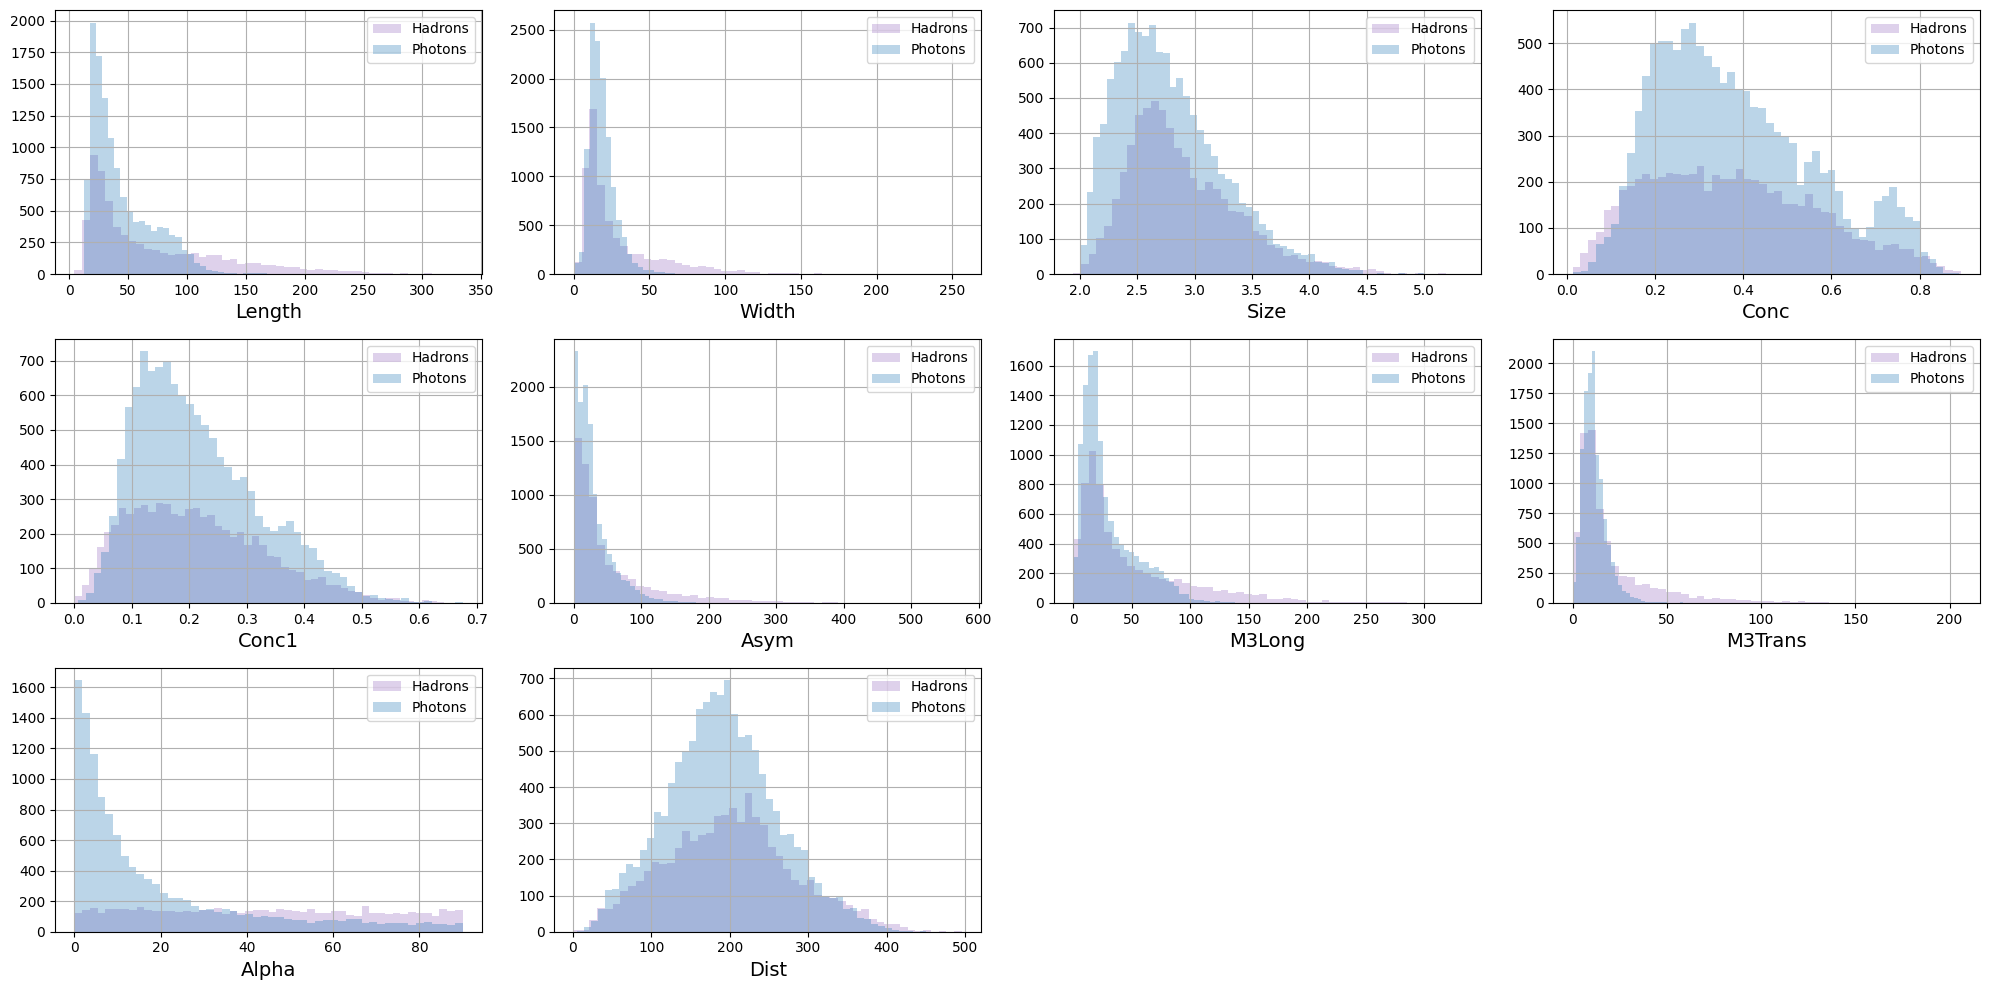

In [573]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [574]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

Собственно, сначала посмотрим, сколько у нас объектов в каждой выборке, потому что я не очень люблю писать графики на matplotlib и могу легко ошибиться :/
Помним, что выше мы определили, что h (адроны) это 0, а g (gamma, фотоны) это 1

In [575]:
print(f'==== Train ====\n hadrons : {np.extract(y_train[:] == 0, y_train).shape[0]} \n photons: {np.extract(y_train[:] == 1, y_train).shape[0]}')
print(f'==== Test ====\n hadrons : {np.extract(y_test[:] == 0, y_test).shape[0]} \n photons: {np.extract(y_test[:] == 1, y_test).shape[0]}')

==== Train ====
 hadrons : 3344 
 photons: 6166
==== Test ====
 hadrons : 3344 
 photons: 6166


In [576]:
def plot_one_hist(X1, X2, names, labels, title, xlabel):
    plt.figure(figsize=(6,6))
  
    plt.grid()
    plt.hist(
        x=[X1[:, 0], X2[:, 0]],
        bins=np.arange(-0.5, 2, 1),
        align='mid',
        label=labels,
        rwidth=0.5,
        alpha=0.3,
        color=('C4', 'C0'),
    )
    plt.xlabel(xlabel)
    plt.legend(loc='best')
    plt.title(title)

    plt.xticks([0, 1], names)

    plt.tight_layout()
    plt.show()

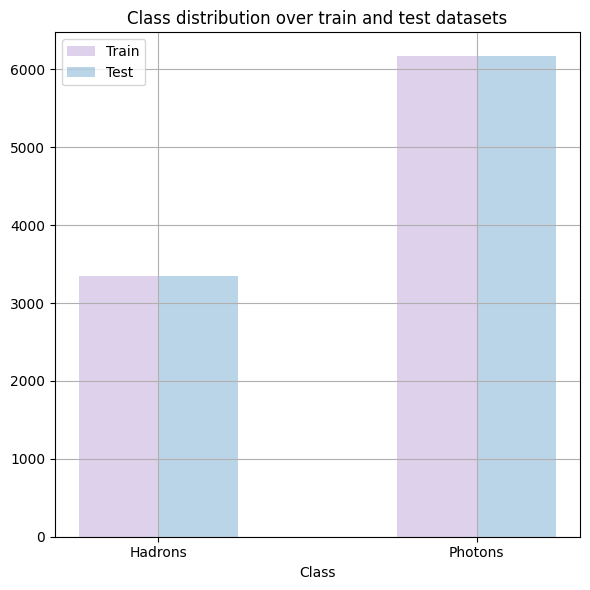

In [577]:
plot_one_hist(
    X1=y_train, 
    X2=y_test, 
    names=['Hadrons', 'Photons'], 
    labels=['Train', 'Test'], 
    title='Class distribution over train and test datasets',
    xlabel='Class'
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [578]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution="normal", random_state=11)
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

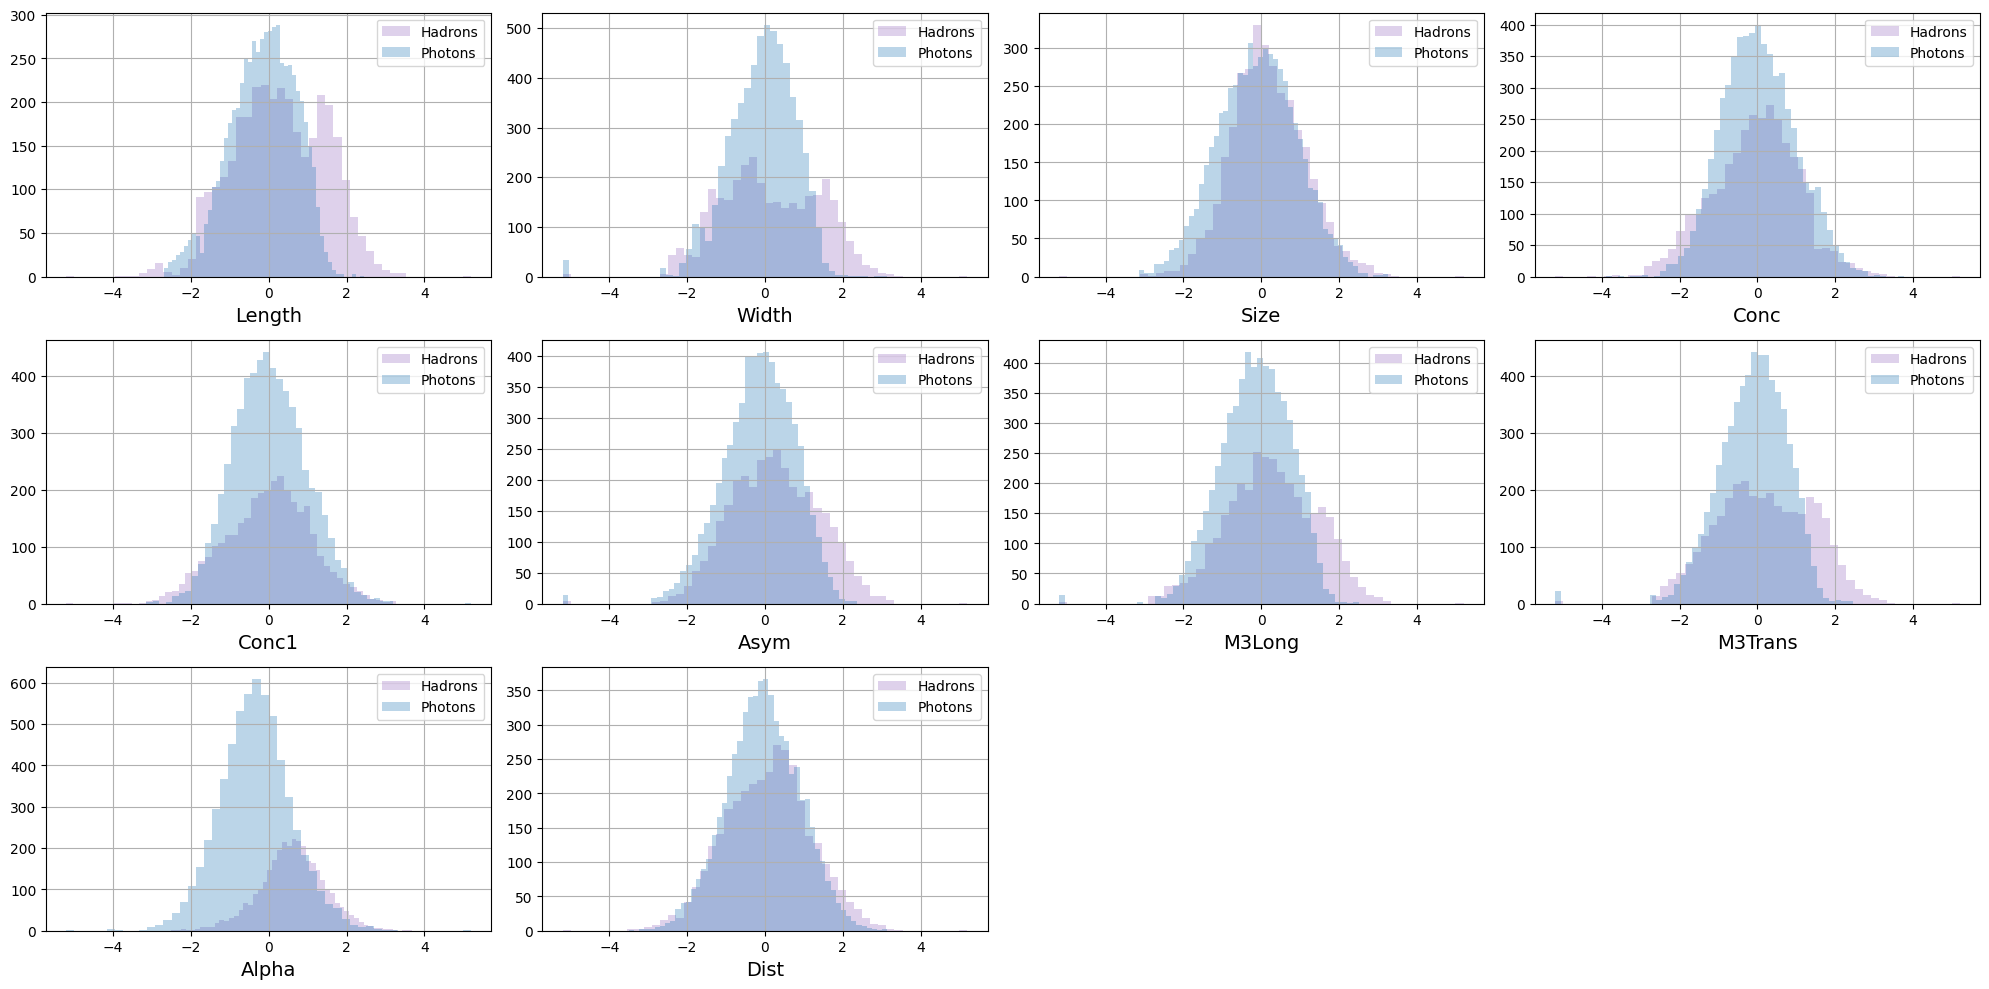

In [579]:
plot_hists(
    X1=X_train_transformed[y_train[:, 0] == 0],
    X2=X_train_transformed[y_train[:, 0] == 1],
    names=names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

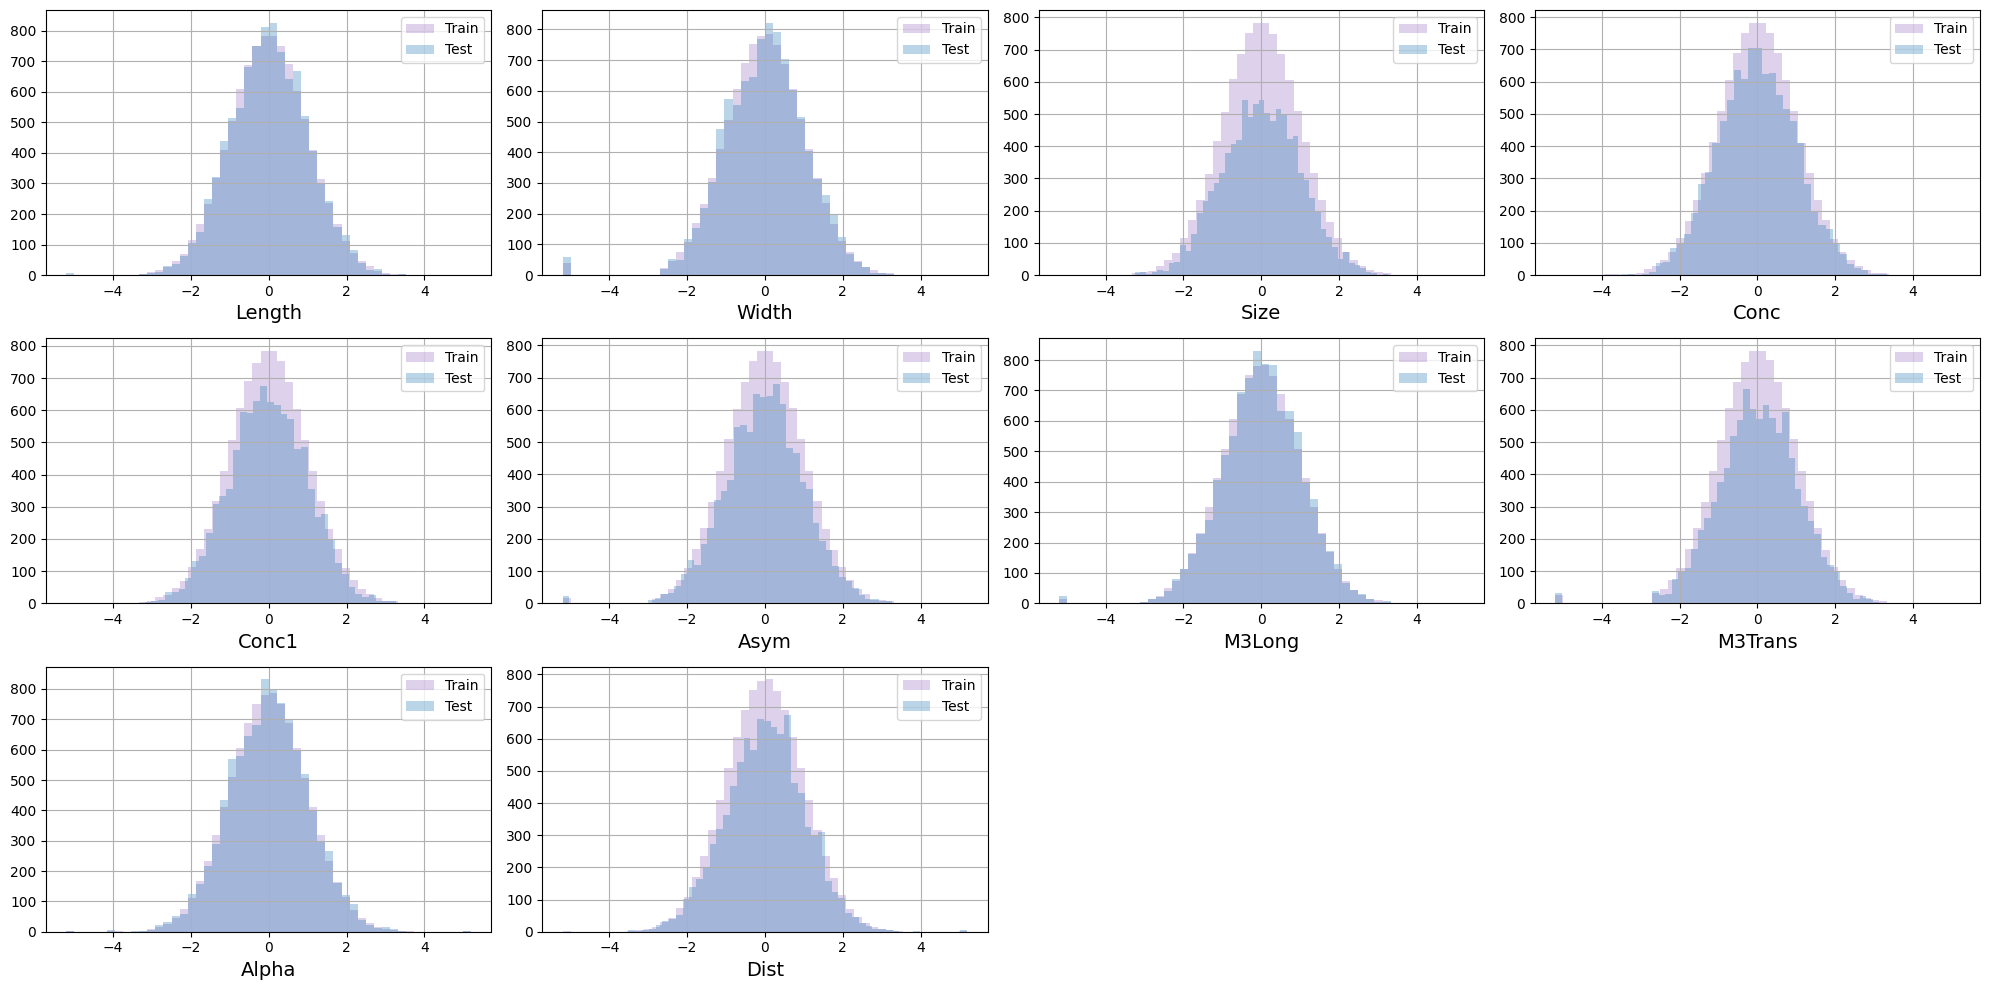

In [581]:
plot_hists(
    X1=X_train_transformed,
    X2=X_test_transformed, 
    names=names, 
    label1="Train",
    label2="Test",
    bins=50
)

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [582]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
else:
    device = "cpu"
    
DEVICE = torch.device(device)

In [583]:
DEVICE

device(type='mps')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [584]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [585]:
def generate(generator, y, latent_dim):
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z_tensor = torch.normal(0, 1, size=(len(y), latent_dim)).to(DEVICE)
    
    X_fake = generator(z_tensor, y_tensor).cpu().detach().numpy()
    
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [586]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Зачем нам тут сигмоида?
На выходе последнего полносвязного слоя мы получим какое-то действительное число. Но оно не говорит нам ничего о том, что дискриминатор определил - фейк или не фейк. Так как у нас бинарная классификация и классы это 0 и 1, то логично перевести наше действительное число на промежуток [0, 1], чтобы получить вероятность принадлежности к классу. Собственно, это и позволяет нам сделать сигмоида

## Задание 6 (0.5 балла)

Реализуйте функцию, которая:
* принимала бы на вход набор сгенерированных и настоящих объектов
* разбивала на train и test с учетом баланса классов (real и fake объектов) с соотношением 3 к 1
* обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых
* после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [587]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

def other_agent_score(X_real, y_real, X_fake, y_fake):
    
    X_concat = np.concatenate([X_real, X_fake])
    y_concat = np.concatenate([y_real, y_fake])

    X_train, X_test, y_train, y_test = train_test_split(
        X_concat, y_concat, stratify=y_concat, test_size=0.25, shuffle=True, random_state=11
    )
    
    logreg = LogisticRegression(random_state=11, max_iter=150).fit(X_train, y_train.ravel())
    gradient_boosting = GradientBoostingClassifier(random_state=11).fit(X_train, y_train.ravel())
    
    lin_reg_score = logreg.score(X_test, y_test)
    boosting_score = gradient_boosting.score(X_test, y_test)

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Ответ на вопрос:
Логично, что мы хотим получить accuracy как можно меньше. Это бы означало, что модель не может отличать фейковый объект от настоящего. Но даже у случайного бинарного классификатор accuracy будет 0.5
Поэтому, наверно, нам бы подошел accuracy в районе 0.5. Это бы означало что модель "тычет пальцем в небо", классифицируя объекты

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [588]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.generator_optimizer = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.discriminator_optimizer = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        
        global_iteration = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # move everything to our device
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                # we limit discriminator weights to prevent gradients from fading 
                map(lambda p: p.data.clamp_(-0.01, 0.01), self.discriminator.parameters())
                
                # now is the time to shine (for our generator)
                # we create sample noise from standard deviation and generate fake objects
                real_objects_count = real_batch.shape[0]
                z = torch.distributions.Normal(0, 1).sample(
                    sample_shape=torch.Size((real_objects_count, self.latent_dim))
                )
                generated_objects = self.generator(z.to(DEVICE), cond_batch)
                
                # then we try to discriminate our fake objects
                fake_discrimination = self.discriminator(
                    torch.cat([real_batch, generated_objects], dim=0),
                    torch.cat([cond_batch, cond_batch], dim=0)
                )
                real_objects_scores, generated_objects_scores = torch.split(fake_discrimination, real_objects_count)
                
                if global_iteration % self.n_critic == 0:
                    # train our generator 
                    self.generator_optimizer.zero_grad()
                    generator_loss = -torch.mean(generated_objects_scores)
                    generator_loss.backward()
                    self.generator_optimizer.step()
                else:
                    # train our discriminator
                    self.discriminator_optimizer.zero_grad()
                    discriminator_loss = torch.mean(generated_objects_scores) - torch.mean(real_objects_scores)
                    discriminator_loss.backward()
                    self.discriminator_optimizer.step()
                
                global_iteration += 1

            # calculate and store loss after an epoch
            Z_noise = torch.normal(mean=0, std=1, size=(len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise.to(DEVICE), y_cond)
            real_prediction = self.discriminator(X_real, y_cond)
            fake_prediction = self.discriminator(X_fake, y_cond)
            loss_epoch = torch.mean(real_prediction) - torch.mean(fake_prediction)
            self.loss_history.append(loss_epoch.cpu().detach())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу функции other_agent_score

            batch_size = 1000
            X_real_batch = X_real[:batch_size]
            Z_batch = torch.normal(mean=0, std=1, size=(batch_size, self.latent_dim), device=DEVICE)
            X_fake_batch = self.generator(Z_batch, y_cond[:batch_size])
            
            other_agent_score(
                X_real=X_real_batch.cpu().detach().numpy(),
                y_real=y_cond[:batch_size].cpu().detach().numpy(),
                X_fake=X_fake_batch.cpu().detach().numpy(),
                y_fake=y_cond[:batch_size].cpu().detach().numpy()
            )

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [589]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train_transformed.shape[1])
discriminator = Discriminator(n_inputs=X_train_transformed.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train_transformed, y_train)

Linear regression score: 0.7
Boosting score: 0.73
Linear regression score: 0.716
Boosting score: 0.722
Linear regression score: 0.726
Boosting score: 0.728
Linear regression score: 0.676
Boosting score: 0.702
Linear regression score: 0.698
Boosting score: 0.724
Linear regression score: 0.686
Boosting score: 0.706
Linear regression score: 0.706
Boosting score: 0.716
Linear regression score: 0.736
Boosting score: 0.704
Linear regression score: 0.77
Boosting score: 0.77
Linear regression score: 0.748
Boosting score: 0.74
Linear regression score: 0.774
Boosting score: 0.746
Linear regression score: 0.78
Boosting score: 0.772
Linear regression score: 0.802
Boosting score: 0.788
Linear regression score: 0.806
Boosting score: 0.792
Linear regression score: 0.866
Boosting score: 0.838
Linear regression score: 0.894
Boosting score: 0.862
Linear regression score: 0.87
Boosting score: 0.858
Linear regression score: 0.896
Boosting score: 0.876
Linear regression score: 0.902
Boosting score: 0.9
Lin

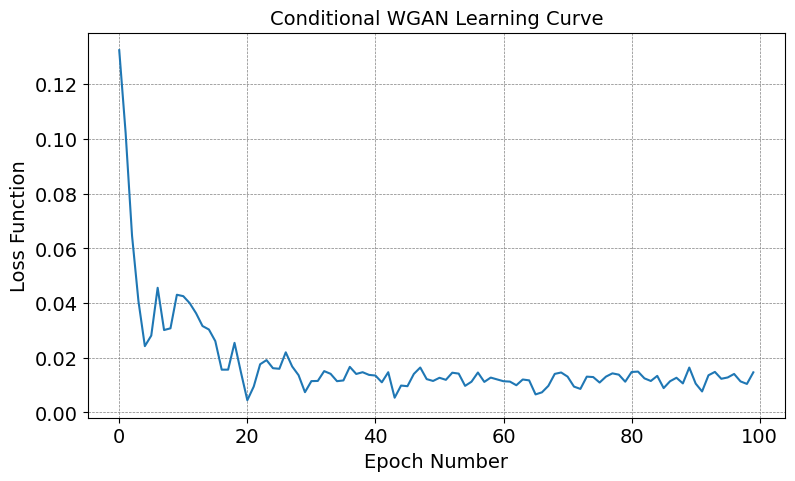

In [591]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [620]:
X_train_reversed = transformer.inverse_transform(X_train_transformed)
X_test_reversed = transformer.inverse_transform(X_test_transformed)

In [621]:
X_fake_train = generate(
    generator=fitter.generator,
    y=y_train, 
    latent_dim=latent_dim
)
X_fake_train_reversed = transformer.inverse_transform(X_fake_train)

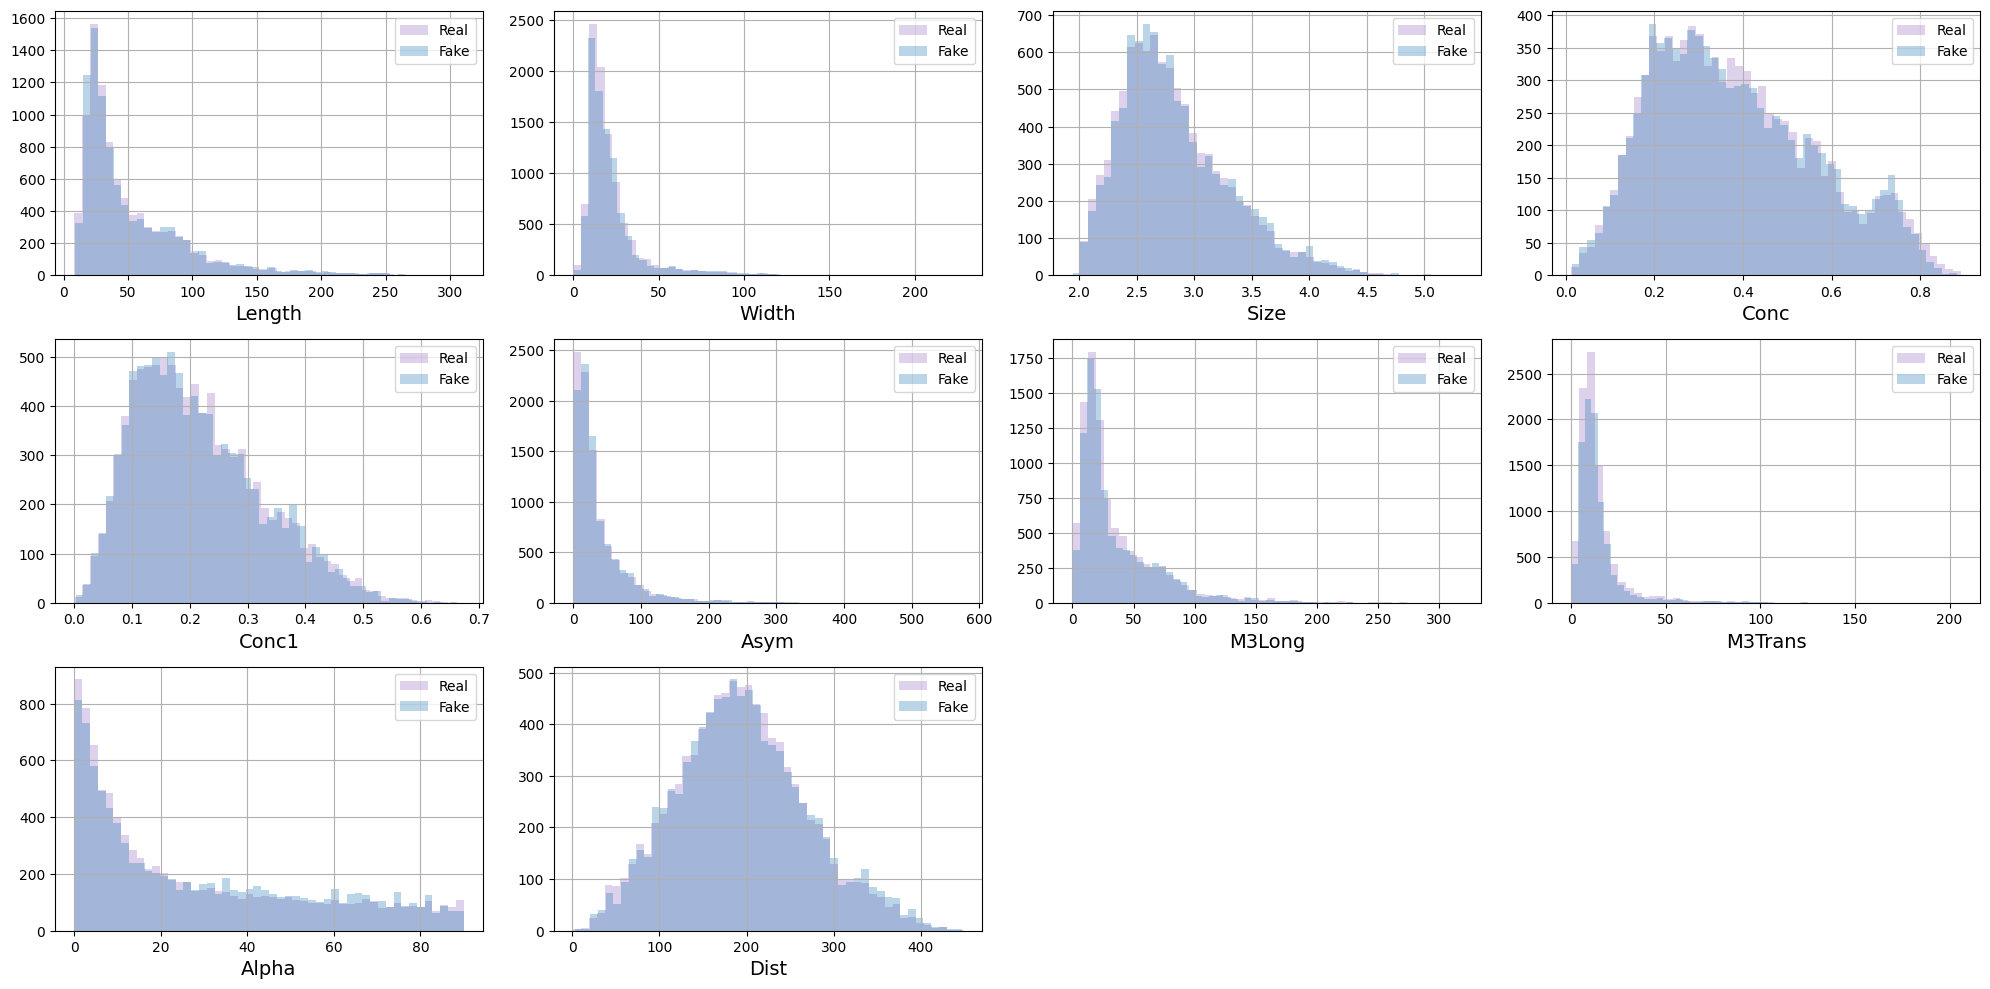

In [622]:
plot_hists(X_train_reversed, X_fake_train_reversed, names, label1="Real", label2="Fake", bins=50)

In [623]:
X_fake_test = generate(
    generator=fitter.generator,
    y=y_test, 
    latent_dim=latent_dim
)
X_fake_test_reversed = transformer.inverse_transform(X_fake_test)

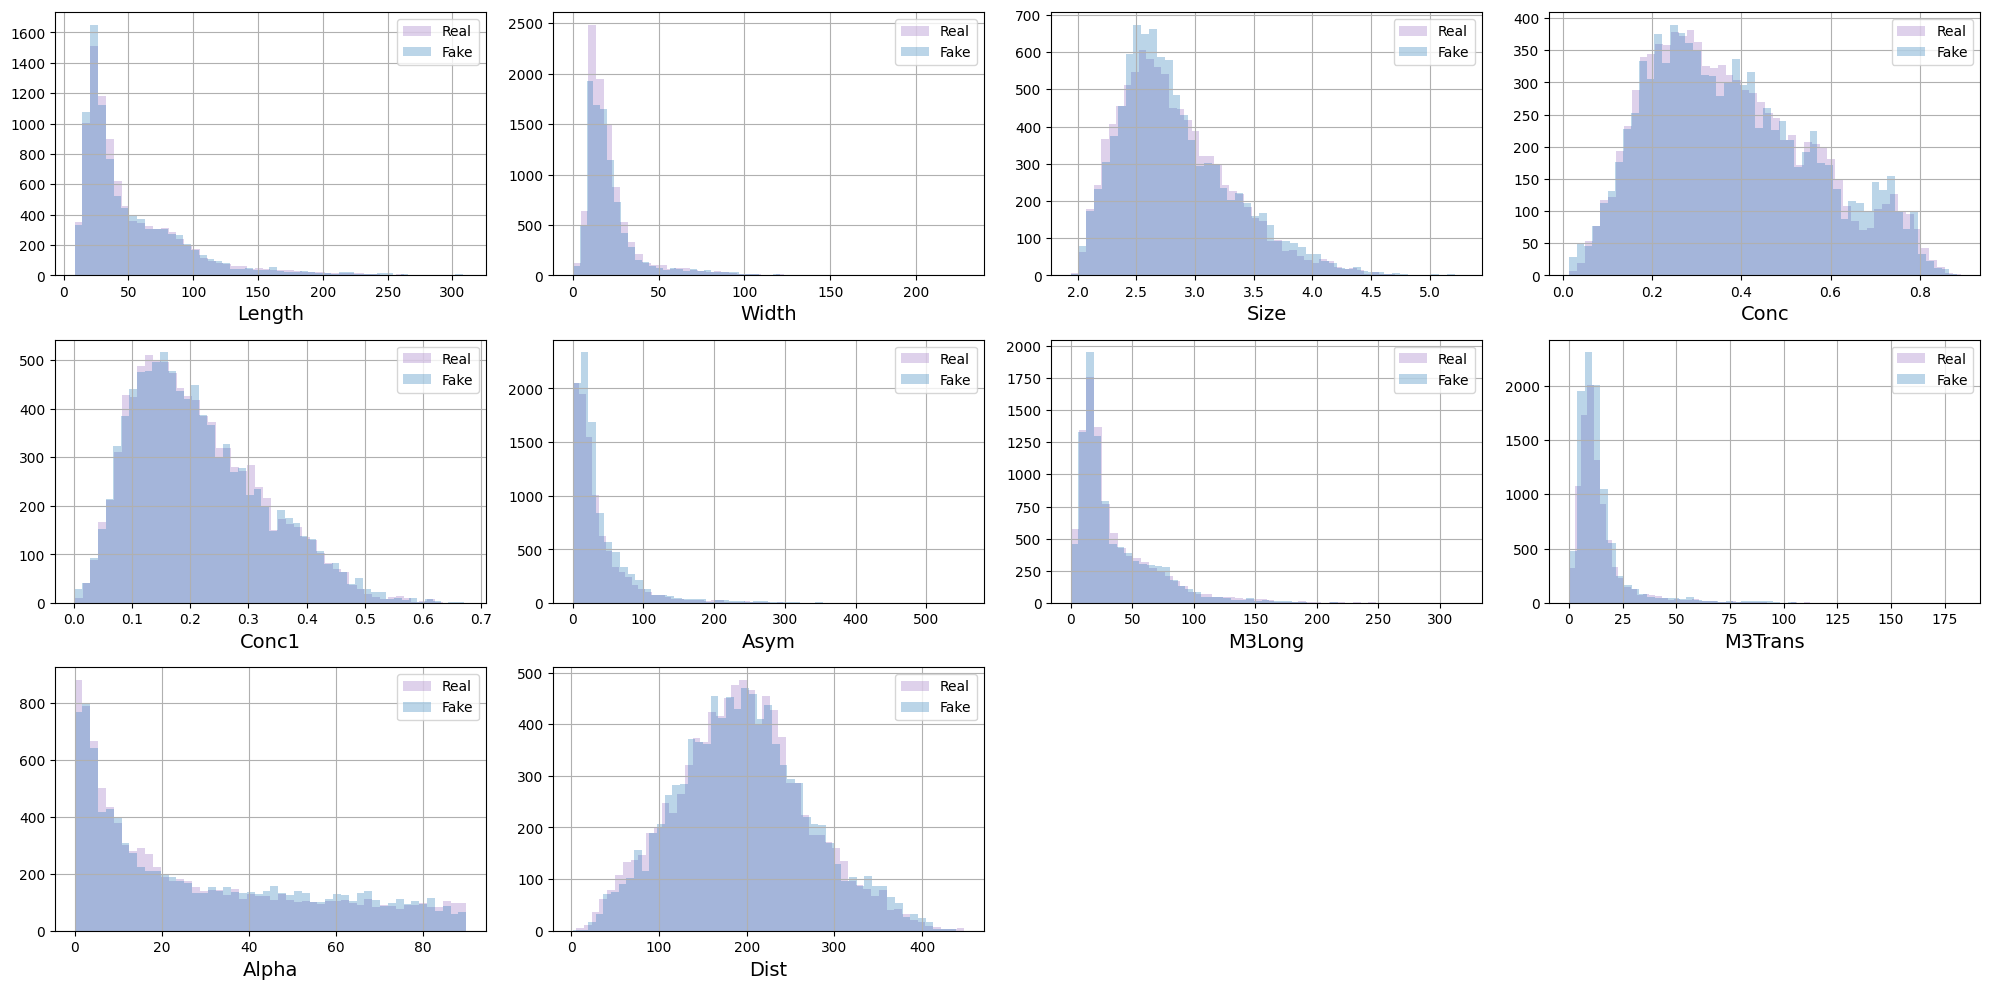

In [624]:
plot_hists(X_test_reversed, X_fake_test_reversed, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [631]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_reversed, X_train_reversed), axis=0)
XX_test = np.concatenate((X_fake_test_reversed, X_test_reversed), axis=0)

yy_train = np.array([0] * len(X_fake_train_reversed) + [1] * len(X_train_reversed))
yy_test = np.array([0] * len(X_fake_test_reversed) + [1] * len(X_test_reversed))

In [632]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier(random_state=11)
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [633]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6772452098129038


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Лучший результат, который у меня получился - 0.6772
Но нам нужно стремиться к ROC AUC == 0.5. Для GANA'а это лучший результат, так как это будет означать, что наш дискриминатор является просто случайным классификатором. В таком случае он совсем не может отличить фейковые объекты от настоящих.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [634]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    return x * (1 - amount) + noise * amount

## Добавим sсheduler, он пригодится вам при обучении модели

In [601]:
from diffusers import DDPMScheduler

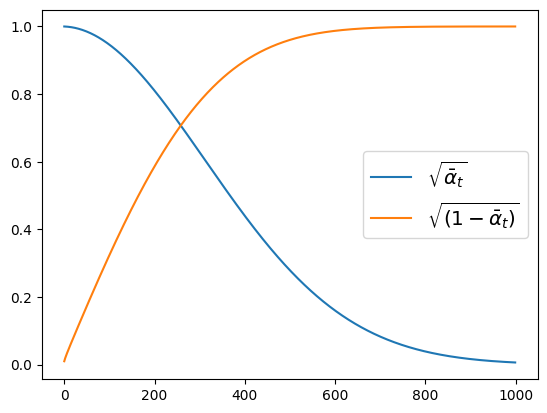

In [602]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, 
    label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [603]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [604]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    X_fake = torch.rand(y.shape, latent_dim).to(DEVICE)
    for i, t in enumerate(scheduler.timesteps):
        with torch.no_grad():
            residual = model(X_fake, y)
            X_fake = scheduler.step(residual, t, X_fake).prev_sample
    
    return X_fake

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [605]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.generator_optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)
        self.scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=3)
        self.loss_fun = nn.MSELoss()

        self.loss_history = []

def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit diffusion
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # copy everything to device
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                
                # create noise
                noise = torch.rand_like(real_batch)
                noised_batch = corrupt(real_batch, noise)
                
                # create prediction from noise and calculate loss
                prediction = self.model(noised_batch, cond_batch)
                generator_loss = self.loss_fun(prediction, real_batch)

                # do training step of our generator
                self.generator_optimizer.zero_grad()
                generator_loss.backward()
                self.generator_optimizer.step()
                
                loss_epoch += generator_loss

            # calculate and store loss after an epoch
            self.loss_history.append(loss_epoch.cpu().detach() / self.batch_size)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            X_real_train, X_real_test, y_cond_train, y_cond_test = train_test_split(
                X_real.cpu().detach(), y_cond.cpu().detach(), stratify=y_cond.cpu().detach(), train_size=1000, shuffle=True
            )
            X_fake_other = generate_with_diffusion(
                model=self.model, 
                y=y_cond,
                latent_dim=self.latent_dim, 
                scheduler=self.scheduler
            )
    
            other_agent_score(
                X_real=X_real_train, 
                y_real=y_cond_train, 
                X_fake=X_fake_other.cpu().detach().numpy(),
                y_fake=y_cond.cpu().detach().numpy()
            )

        # Turn off training
        self.model.train(False)

In [607]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train_transformed.shape[1])

diffusionFitter = DiffusionFitter(
    model=model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train_transformed, y_train)

Linear regression score: 0.6537290715372908
Boosting score: 0.6533485540334856
Linear regression score: 0.6601978691019786
Boosting score: 0.671613394216134
Linear regression score: 0.6461187214611872
Boosting score: 0.6571537290715372
Linear regression score: 0.6525875190258752
Boosting score: 0.6575342465753424
Linear regression score: 0.6506849315068494
Boosting score: 0.662861491628615
Linear regression score: 0.643455098934551
Boosting score: 0.6624809741248098
Linear regression score: 0.6510654490106544
Boosting score: 0.6689497716894978
Linear regression score: 0.6503044140030442
Boosting score: 0.6617199391171994
Linear regression score: 0.6373668188736682
Boosting score: 0.6560121765601218
Linear regression score: 0.6464992389649924
Boosting score: 0.6624809741248098
Linear regression score: 0.6579147640791476
Boosting score: 0.6579147640791476
Linear regression score: 0.654490106544901
Boosting score: 0.6662861491628614
Linear regression score: 0.6464992389649924
Boosting sco

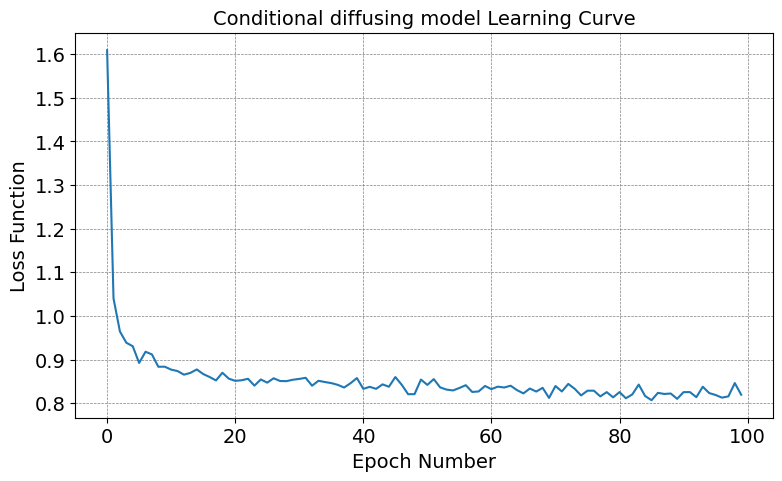

In [608]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [635]:
X_train_reversed = transformer.inverse_transform(X_train_transformed)
X_test_reversed = transformer.inverse_transform(X_test_transformed)

In [636]:
X_fake_train = generate_with_diffusion(
    model=diffusionFitter.model, 
    y=torch.tensor(y_train, dtype=torch.float, device=DEVICE), 
    latent_dim=latent_dim,
    scheduler=diffusionFitter.scheduler
).cpu().detach()

X_fake_train_reversed = transformer.inverse_transform(X_fake_train)

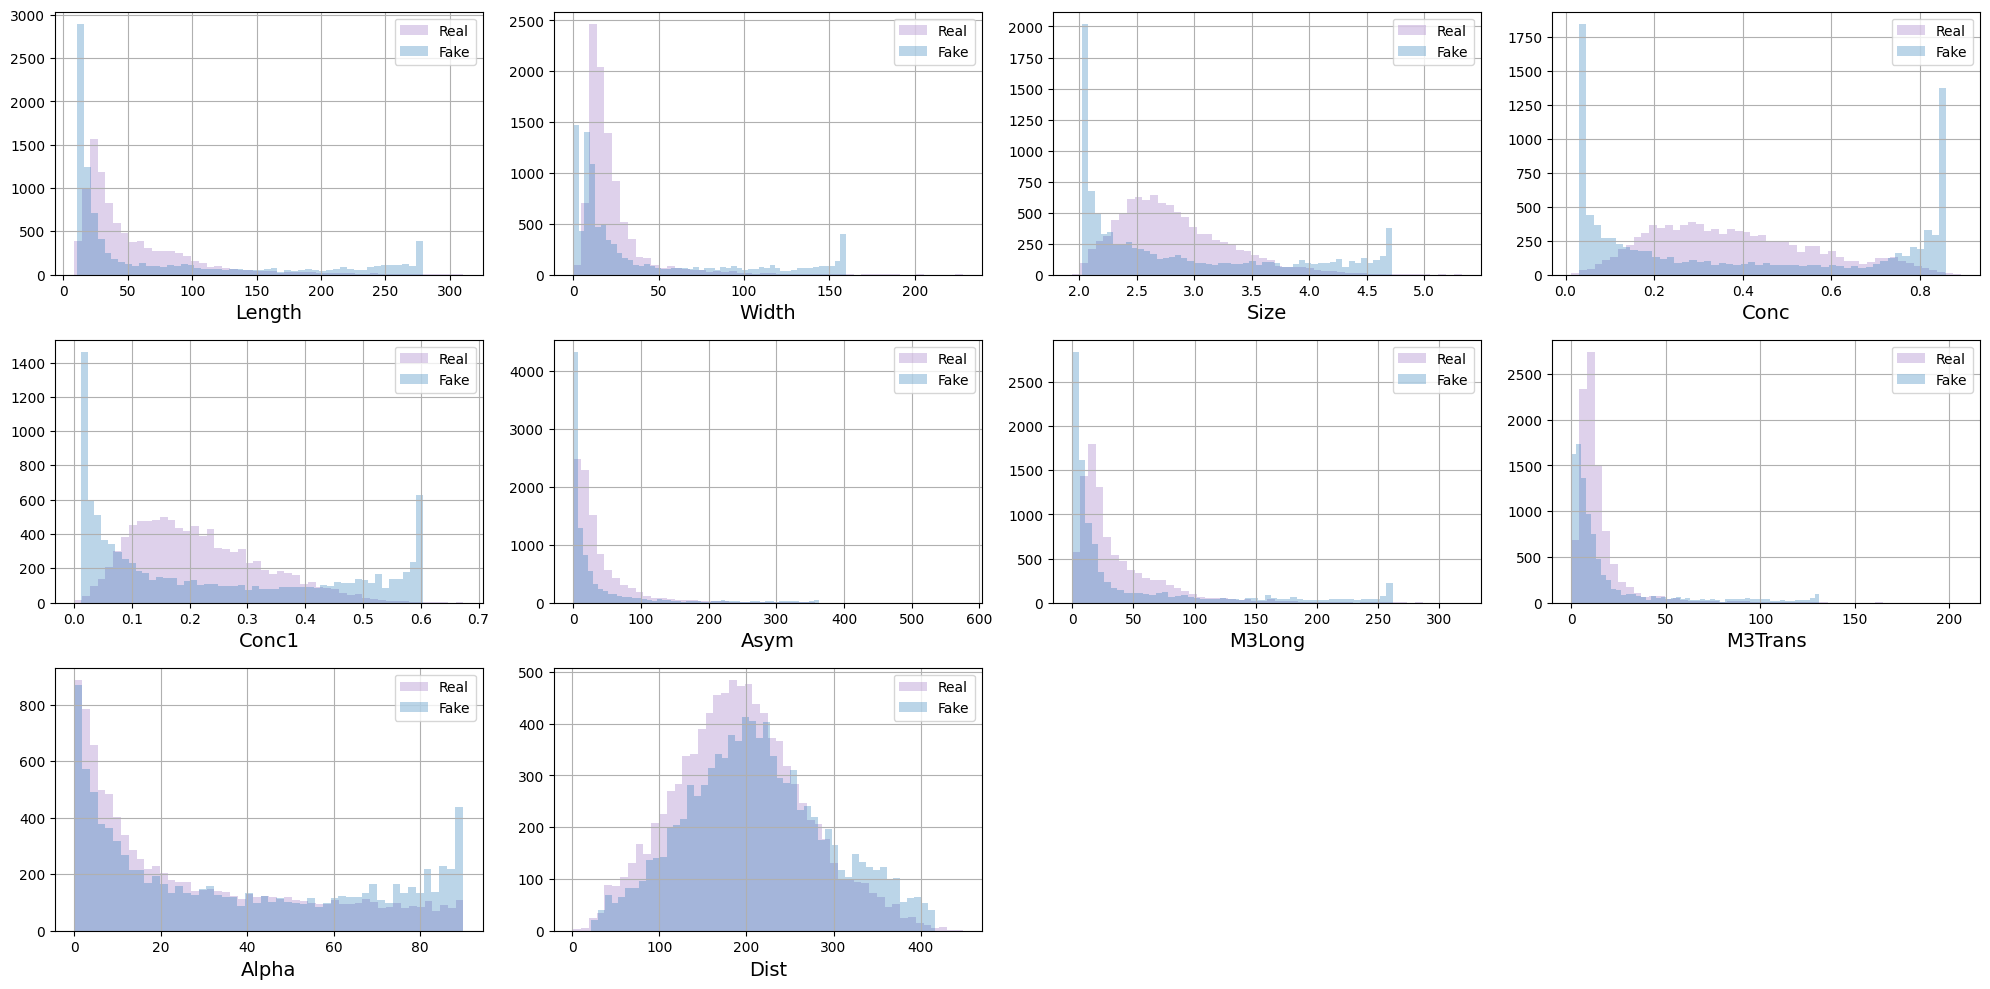

In [637]:
plot_hists(X_train_reversed, X_fake_train_reversed, names, label1="Real", label2="Fake", bins=50)

In [638]:
X_fake_test = generate_with_diffusion(
    model=diffusionFitter.model,
    y=torch.tensor(y_test, dtype=torch.float, device=DEVICE), 
    latent_dim=latent_dim, 
    scheduler=diffusionFitter.scheduler
).cpu().detach()
X_fake_test_reversed = transformer.inverse_transform(X_fake_test)

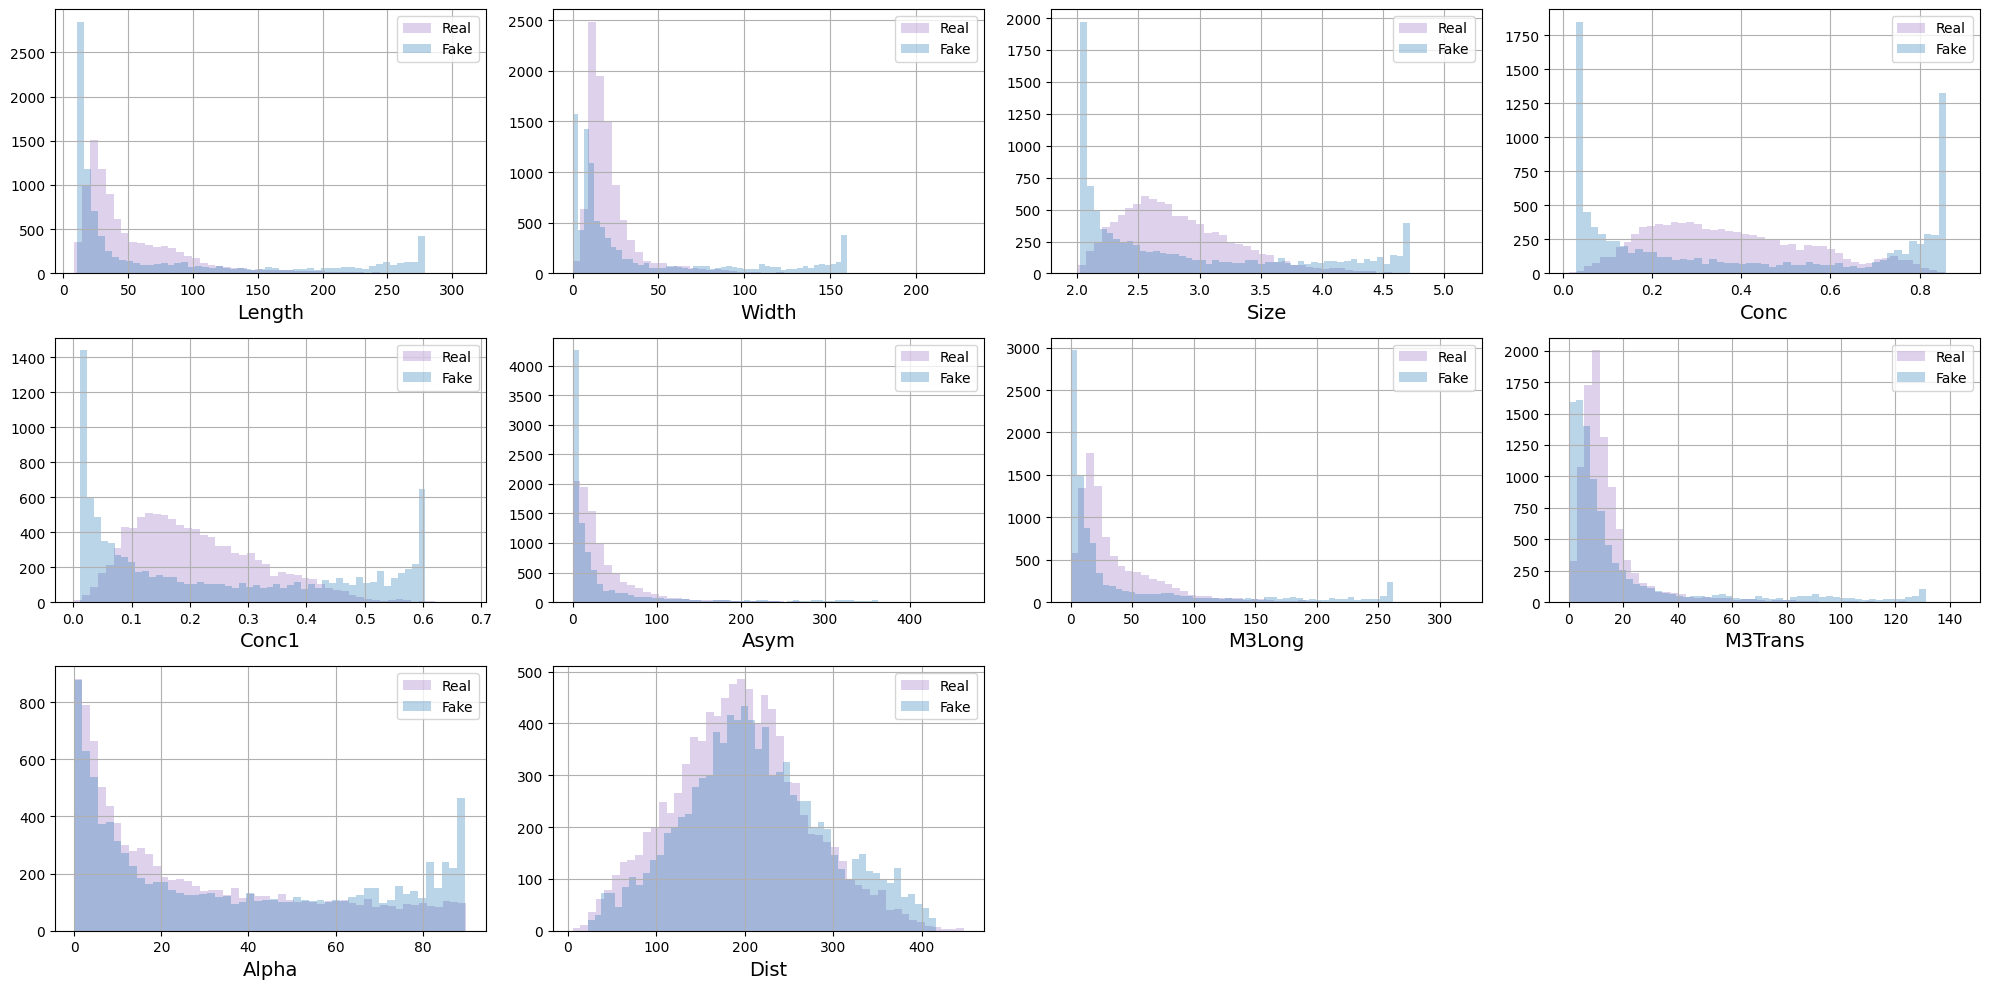

In [639]:
plot_hists(X_test_reversed, X_fake_test_reversed, names, label1="Real", label2="Fake", bins=50)

In [640]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_reversed, X_train_reversed), axis=0)
XX_test = np.concatenate((X_fake_test_reversed, X_test_reversed), axis=0)

yy_train = np.array([0] * len(X_fake_train_reversed) + [1] * len(X_train_reversed))
yy_test = np.array([0] * len(X_fake_test_reversed) + [1] * len(X_test_reversed))

In [641]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier(random_state=11)
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [643]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_proba.round(), normalize=False) / len(yy_test)
print("ROC AUC = ", auc)
print("accuracy =", acc)

ROC AUC =  0.9996250501713287
accuracy = 0.9940063091482649


Собственно, как и с GAN'ами мы стремимся к ROC AUC == 0.5. Но у тут получилась по факту 1, что на самом деле очень плохо :). Это означает, что наш градиентный бустинг без проблем отличает сгенерированные объекты. Да и даже на графиках видно, что практически все распределения сильно отличаются.
Если сравнивать с написанным выше WGAN'ом, то бесспорно WGAN показал себя намного лучше при том, что архитектуры у моделей-генераторов одинаковые

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

На самом деле было очень интересно и в меру сложно (особенно сложно не путать переменные)
Но наверно, хочется, чтобы по диффузионкам была прям отдельная большая дз, в которой можно было бы углубленно покопаться и поэксперементировать.
Надеюсь, на глубинному обучении 1 оно будет))